In [1]:
import os
import torch
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import seaborn as sns

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_ROOT = "/usr/xtmp/cjb131/output_images/2"
MAX_IMAGES = 1000  # maximum number of images to use from each directory

original_dir = os.path.join(IMG_ROOT, "original")
variant_dirs = {
    "signed": os.path.join(IMG_ROOT, "signed"),
    "signed_compressed_100": os.path.join(IMG_ROOT, "signed_compressed_100"),
    "signed_compressed_90": os.path.join(IMG_ROOT, "signed_compressed_90"),
    "signed_compressed_75": os.path.join(IMG_ROOT, "signed_compressed_75"),
    "unsigned_compressed_100": os.path.join(IMG_ROOT, "unsigned_compressed_100"),
    "unsigned_compressed_90": os.path.join(IMG_ROOT, "unsigned_compressed_90"),
    "unsigned_compressed_75": os.path.join(IMG_ROOT, "unsigned_compressed_75")
}

In [3]:
vit = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT).to(DEVICE)
vit.eval()

# ViT expects images of size 224x224 and normalized
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
def load_image_tensor(path):
    img_tensor = torch.load(path)
    img_tensor = img_tensor.float().to(DEVICE)
    return img_tensor

def get_embedding(img_tensor):
    resized = torch.nn.functional.interpolate(img_tensor.unsqueeze(0), size=224, mode='bilinear', align_corners=False)
    normalized = torch.clone(resized)
    mean = torch.tensor([0.485, 0.456, 0.406], device=DEVICE).view(1,3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225], device=DEVICE).view(1,3,1,1)
    normalized = (normalized - mean) / std

    with torch.no_grad():
        emb = vit(normalized)
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)
    return emb.squeeze(0)

def compute_l2_distance(emb1, emb2):
    return torch.norm(emb1 - emb2, p=2).item()

In [5]:
all_original_files = sorted(os.listdir(original_dir))

# filter to only images that exist in dirs
filtered_files = []
for f in all_original_files:
    if all(os.path.exists(os.path.join(variant_dirs[v], f)) for v in variant_dirs): #check if f in all var dirs
        filtered_files.append(f)

all_original_files = filtered_files[:MAX_IMAGES]

dist_signed = []
dist_signed_compressed_100 = []
dist_signed_compressed_90 = []
dist_signed_compressed_75 = []
dist_unsigned_compressed_100 = []
dist_unsigned_compressed_90 = []
dist_unsigned_compressed_75 = []

original_embeddings = [] # for diff images

print("loading original embeddings...")
for f in tqdm(all_original_files):
    orig_path = os.path.join(original_dir, f)
    orig_img = load_image_tensor(orig_path)
    orig_emb = get_embedding(orig_img)
    original_embeddings.append(orig_emb)

original_embeddings = torch.stack(original_embeddings)  # shape: (N,1000)

loading original embeddings...


100%|██████████| 904/904 [04:51<00:00,  3.10it/s]


In [6]:
print("comparing variants to originals...")
for i, f in enumerate(tqdm(all_original_files)):
    orig_emb = original_embeddings[i]
    
    def process_variant(variant_name, dist_list):
        var_path = os.path.join(variant_dirs[variant_name], f)
        var_img = load_image_tensor(var_path)
        var_emb = get_embedding(var_img)
        dist = compute_l2_distance(orig_emb, var_emb)
        dist_list.append(dist)

    process_variant("signed", dist_signed)
    process_variant("signed_compressed_100", dist_signed_compressed_100)
    process_variant("signed_compressed_90", dist_signed_compressed_90)
    process_variant("signed_compressed_75", dist_signed_compressed_75)
    process_variant("unsigned_compressed_100", dist_unsigned_compressed_100)
    process_variant("unsigned_compressed_90", dist_unsigned_compressed_90)
    process_variant("unsigned_compressed_75", dist_unsigned_compressed_75)

comparing variants to originals...


100%|██████████| 904/904 [31:17<00:00,  2.08s/it] 


In [7]:
print("computing 'different images' ...")
num_images = len(all_original_files)
dist_different = []
for _ in range(num_images):
    idx1, idx2 = random.sample(range(num_images), 2)
    emb1 = original_embeddings[idx1]
    emb2 = original_embeddings[idx2]
    dist = torch.norm(emb1 - emb2, p=2).item()
    dist_different.append(dist)

computing 'different images' ...


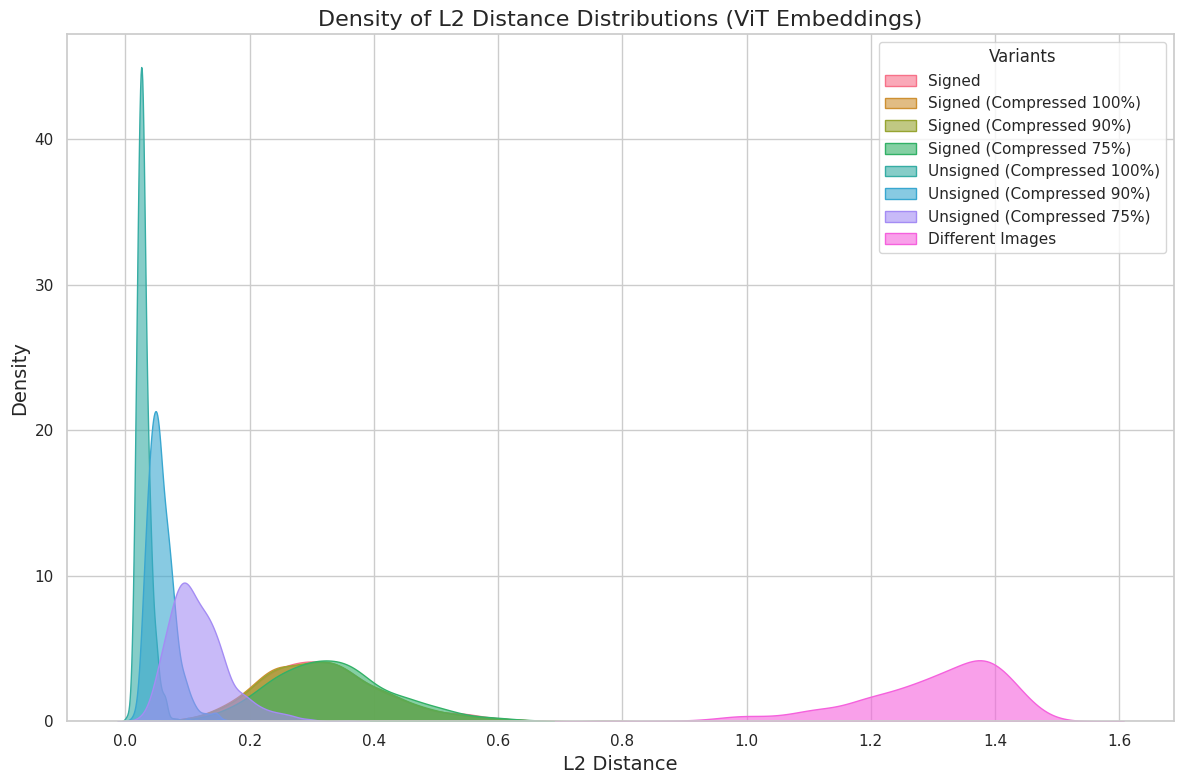

In [8]:
data = [
    (dist_signed, "Signed"),
    (dist_signed_compressed_100, "Signed (Compressed 100%)"),
    (dist_signed_compressed_90, "Signed (Compressed 90%)"),
    (dist_signed_compressed_75, "Signed (Compressed 75%)"),
    (dist_unsigned_compressed_100, "Unsigned (Compressed 100%)"),
    (dist_unsigned_compressed_90, "Unsigned (Compressed 90%)"),
    (dist_unsigned_compressed_75, "Unsigned (Compressed 75%)"),
    (dist_different, "Different Images")
]

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 8))

palette = sns.color_palette("husl", len(data))

for (dist_array, label), color in zip(data, palette):
    sns.kdeplot(dist_array, fill=True, label=label, alpha=0.6, color=color)

plt.xlabel('L2 Distance', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Density of L2 Distance Distributions (ViT Embeddings)', fontsize=16)
plt.legend(title="Variants", loc='upper right')
plt.tight_layout()
plt.show()

In [9]:
def print_stats(name, arr):
    arr_np = np.array(arr)
    print(f"{name} - Mean: {arr_np.mean():.4f}, Std: {arr_np.std():.4f}, Median: {np.median(arr_np):.4f}")

print_stats("Signed", dist_signed)
print_stats("Signed Compressed 100", dist_signed_compressed_100)
print_stats("Signed Compressed 90", dist_signed_compressed_90)
print_stats("Signed Compressed 75", dist_signed_compressed_75)
print_stats("Unsigned Compressed 100", dist_unsigned_compressed_100)
print_stats("Unsigned Compressed 90", dist_unsigned_compressed_90)
print_stats("Unsigned Compressed 75", dist_unsigned_compressed_75)
print_stats("Different Images", dist_different)

Signed - Mean: 0.3214, Std: 0.0987, Median: 0.3114
Signed Compressed 100 - Mean: 0.3177, Std: 0.0979, Median: 0.3120
Signed Compressed 90 - Mean: 0.3205, Std: 0.0980, Median: 0.3123
Signed Compressed 75 - Mean: 0.3346, Std: 0.0979, Median: 0.3272
Unsigned Compressed 100 - Mean: 0.0298, Std: 0.0133, Median: 0.0274
Unsigned Compressed 90 - Mean: 0.0575, Std: 0.0224, Median: 0.0534
Unsigned Compressed 75 - Mean: 0.1177, Std: 0.0471, Median: 0.1096
Different Images - Mean: 1.2998, Std: 0.1160, Median: 1.3257
